In [1]:
import pandas as pd
import numpy as np
import json
import pandas as pd
from cobra import Model, Reaction, Metabolite
import pickle
from ast import literal_eval
import cobra
import sys
import warnings
warnings.filterwarnings("ignore")
from cobra.flux_analysis import pfba
import random
import multiprocessing
from functools import partial
import copy
from tqdm import tqdm
import gurobipy
gurobipy.setParam('OutputFlag', 0)

import sys
# sys.path.append('../Script/')
sys.path.append('../retrosynthesis/')

from common import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [2]:
yeast8_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/Yeast-MetaTwin.yml'

yeast8U_result_path = '../../Results/analysis/yeast8U_aminoacid_score.pickle'
yeast8_result_path = '../../Results/analysis/yeast8_aminoacid_score.pickle'
figure_6a_path = '../../Results/Figures/figs6-d'

# figure_S12_path = '../../Results/Figures/figs12.pdf'

In [3]:
yeast8 = cobra.io.load_yaml_model(yeast8_path)
yeast8U = cobra.io.load_yaml_model(yeast8U_path)

# List of amino acids

In [4]:
list1 = ['s_0955','s_0965','s_0969','s_0981','s_0999','s_1003','s_1006','s_1016','s_1021','s_1025','s_1029','s_1032','s_1035','s_1039','s_1014','s_1045','s_1048','s_1051','s_1056']

In [5]:
def get_aminoacid_id(name,model):
    aminoacid_id = ''
    for met in model.metabolites:
        if met.name == name and met.compartment == 'e':
            aminoacid_id = met.id
    return aminoacid_id

def calculate_FBA(Target_met, model):
    exchange_reaction = get_exchange_reaction(Target_met, model)
    model.reactions.get_by_id('r_4046').bounds = (0, 0)
    model.objective = model.reactions.get_by_id(exchange_reaction)
    
    # Perform parsimonious FBA
    try:
        solution = pfba(model)
        flux_tmp = solution.fluxes.get(exchange_reaction, 0)
        if abs(flux_tmp) <= 0.001:
            flux_tmp = 0
    except Exception as e:
        print(f"Error during pFBA optimization: {e}")
        flux_tmp = 0
    
    # Remove the added reaction if needed
    if 'DM_' in exchange_reaction:
        try:
            model.remove_reactions([exchange_reaction])
        except Exception as e:
            print(f"Error removing reaction {exchange_reaction}: {e}")
    
    return flux_tmp, solution

def check_gene_ess(Target_met,model,modelU):
    FBA_res = calculate_FBA(Target_met,model)
    res = {'gene':[],
        'FBA_initial':[],
        'FBA_modify':[]}
    for i in model.reactions:
        if abs(i.flux)>0.001:
            if len(i.gene_reaction_rule)>0:
                # print(i.gene_reaction_rule.replace(' or ',' ').replace(' and ',' ').split(' '))
                gpr_lst = i.gene_reaction_rule.replace('(','').replace(')','').replace(' or ',' ').replace(' and ',' ').split(' ')
                for gene in gpr_lst:
                    if gene not in res['gene']:
                        res['gene'].append(gene)
                        res['FBA_initial'].append(FBA_res)

    for knock_gene in res['gene']:
        change_reaction ={}
        for reaction in modelU.reactions:
            ess = True
            if 'or' in reaction.gene_reaction_rule:
                gpr_or_lst =  reaction.gene_reaction_rule.split(' or ')
                for i in gpr_or_lst:
                    if knock_gene not in i:
                        ess = False 
                    break
            else:
                if knock_gene not in reaction.gene_reaction_rule:
                    ess = False

            if ess:
                change_reaction[reaction.id] = reaction.bounds
                reaction.bounds = (0,0)

        FBA_tmp = calculate_FBA(Target_met,modelU)
        res['FBA_modify'].append(FBA_tmp)
        for id,old_bounds in change_reaction.items():
            modelU.reactions.get_by_id(id).bounds = old_bounds
    return res

def get_central_carbon_metabolism_gene_lst(model):
    central_carbon_metabolism = [['Glycolysis / gluconeogenesis'],['Citrate cycle (TCA cycle)'],['Pentose phosphate pathway']]
    central_carbon_metabolism_gene_lst = []
    for i in model.reactions:
        if i.subsystem in central_carbon_metabolism:
            gene_lst_tmp = i.gene_reaction_rule.replace('(','').replace(')','').replace(' or ',' ').replace(' and ',' ').split(' ')
            for gene in gene_lst_tmp:
                if gene != '' and gene not in central_carbon_metabolism_gene_lst:
                    central_carbon_metabolism_gene_lst.append(gene)
    return central_carbon_metabolism_gene_lst


def knock_gene_ratio(Target_met, model, modelU, fraction):
    central_carbon_metabolism_gene_lst = get_central_carbon_metabolism_gene_lst(model)
    FBA_res, solution = calculate_FBA(Target_met, model)
    res = {'gene': [],
           'FBA_initial': [],
           'FBA_modify': []}
    
    for i in model.reactions:
        if abs(solution.fluxes[i.id]) > 0.001:
            if len(i.gene_reaction_rule) > 0:
                gpr_lst = i.gene_reaction_rule.replace('(', '').replace(')', '').replace(' or ', ' ').replace(' and ', ' ').split(' ')
                for gene in gpr_lst:
                    if gene not in res['gene'] and gene not in central_carbon_metabolism_gene_lst:
                        res['gene'].append(gene)
                        res['FBA_initial'].append(FBA_res)
    
    gene_lst = res['gene']
    num_genes_to_select = int(len(gene_lst) * fraction)
    knock_gene_lst = random.sample(gene_lst, num_genes_to_select)
    change_reaction = {}

    for knock_gene in knock_gene_lst:
        for reaction in modelU.reactions:
            ess = True
            if 'or' in reaction.gene_reaction_rule:
                gpr_or_lst = reaction.gene_reaction_rule.split(' or ')
                for i in gpr_or_lst:
                    if knock_gene not in i:
                        ess = False
                    break
            else:
                if knock_gene not in reaction.gene_reaction_rule:
                    ess = False

            if ess and reaction.id not in change_reaction.keys():
                change_reaction[reaction.id] = reaction.bounds
                reaction.bounds = (0, 0)

    FBA_tmp, _ = calculate_FBA(Target_met, modelU)
    for id, old_bounds in change_reaction.items():
        modelU.reactions.get_by_id(id).bounds = old_bounds

    return FBA_tmp / FBA_res

In [6]:
aminoacid = ['L-alanine', 'L-arginine', 'L-asparagine','L-aspartate', 'L-cysteine', 'L-glutamine', 'L-glycine', 'L-histidine', 'L-isoleucine', 'L-leucine', 'L-lysine', 
             'L-methionine', 'L-phenylalanine', 'L-proline', 'L-serine', 'L-homoserine', 'L-threonine', 'L-tryptophan', 'L-tyrosine', 'L-valine']

## yeast8

In [7]:
def process_aminoacid(name, model):
    result = []
    for ratio in range(1, 6):
        # print(name,ratio/10)
        model_copy = copy.deepcopy(model)  # Each loop replicates a model
        Target_met = get_aminoacid_id(name, model_copy)
        score_lst = []
        num = 0
        while num < 100:
            with model_copy:
                num += 1
                score_lst.append(knock_gene_ratio(Target_met, model_copy, model_copy, ratio/10))
        result.append({'aminoacid': name, 'knockratio': ratio/10, 'score': score_lst})
    return result

pool = multiprocessing.Pool(processes=30)
results = pool.map(partial(process_aminoacid, model=yeast8), aminoacid)
pool.close()
pool.join()

yeast8_result = {'aminoacid': [], 'knockratio': [], 'score': []}
for result in results:
    for item in result:
        yeast8_result['aminoacid'].append(item['aminoacid'])
        yeast8_result['knockratio'].append(item['knockratio'])
        yeast8_result['score'].append(item['score'])

dump_file(yeast8_result,yeast8_result_path)

## yeast8U

In [8]:
def process_aminoacid(name, model):
    result = []
    for ratio in range(1, 6):
        print(name,ratio/10)
        model_copy = copy.deepcopy(model)  # Each loop replicates a model
        Target_met = get_aminoacid_id(name, model_copy)
        score_lst = []
        num = 0
        while num < 100:
            with model_copy:
                num += 1
                score_lst.append(knock_gene_ratio(Target_met, model_copy, model_copy, ratio/10))
        result.append({'aminoacid': name, 'knockratio': ratio/10, 'score': score_lst})
    return result

pool = multiprocessing.Pool(processes=30)
results = pool.map(partial(process_aminoacid, model=yeast8U), aminoacid)
pool.close()
pool.join()

yeast8U_result = {'aminoacid': [], 'knockratio': [], 'score': []}
for result in results:
    for item in result:
        yeast8U_result['aminoacid'].append(item['aminoacid'])
        yeast8U_result['knockratio'].append(item['knockratio'])
        yeast8U_result['score'].append(item['score'])

dump_file(yeast8U_result, yeast8U_result_path)

L-arginine 0.1
L-alanine 0.1
L-asparagine 0.1
L-aspartate 0.1
L-cysteine 0.1
L-glutamine 0.1
L-glycine 0.1
L-histidine 0.1
L-isoleucine 0.1
L-leucine 0.1
L-lysine 0.1
L-methionine 0.1
L-proline 0.1
L-phenylalanine 0.1
L-serine 0.1
L-homoserine 0.1
L-threonine 0.1
L-tryptophan 0.1
L-tyrosine 0.1
L-valine 0.1


L-alanine 0.2
L-serine 0.2
L-cysteine 0.2
L-aspartate 0.2
L-valine 0.2
L-isoleucine 0.2
L-tyrosine 0.2
L-threonine 0.2
L-phenylalanine 0.2
L-leucine 0.2
L-glycine 0.2
L-methionine 0.2
L-asparagine 0.2
L-tryptophan 0.2
L-histidine 0.2
L-proline 0.2
L-homoserine 0.2
L-glutamine 0.2
L-alanine 0.3
L-serine 0.3
L-arginine 0.2
L-cysteine 0.3
L-valine 0.3
L-aspartate 0.3
L-lysine 0.2
L-isoleucine 0.3
L-tyrosine 0.3
L-glycine 0.3
L-alanine 0.4
L-threonine 0.3
L-phenylalanine 0.3
L-leucine 0.3
L-methionine 0.3
L-asparagine 0.3
L-tryptophan 0.3
L-serine 0.4
L-histidine 0.3
L-proline 0.3
L-homoserine 0.3
L-cysteine 0.4
L-valine 0.4
L-glutamine 0.3
L-alanine 0.5
L-aspartate 0.4
L-isoleucine 0.4
L-serine 0.5
L-tyrosine 0.4
L-arginine 0.3
L-glycine 0.4
L-phenylalanine 0.4
L-threonine 0.4
L-leucine 0.4
L-methionine 0.4
L-asparagine 0.4
L-tryptophan 0.4
L-cysteine 0.5
L-histidine 0.4
L-valine 0.5
L-lysine 0.3
L-proline
 0.4L-homoserine 0.4
L-aspartate 0.5
L-isoleucine 0.5
L-tyrosine 0.5
L-glycine 0.5


# figs6-d

In [9]:
yeast8U_result = load_pickle(yeast8U_result_path)
yeast8_result = load_pickle(yeast8_result_path)

yeast8U_result_df = pd.DataFrame(yeast8U_result)
yeast8_result_df = pd.DataFrame(yeast8_result)

In [10]:
def plot_dual_kernel_density(data1, data2, figure_path, aminoacid, max_ylim, ratio):
    # Set common parameters
    plt.figure(figsize=(2.5, 0.55), dpi=400)
    plt.rcParams.update({'font.size': 7})
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42

    # Set axis styles
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    # Hide the right and top axis borders
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Use Seaborn to plot two kernel density estimation plots
    sns.kdeplot(data1, fill=True, color='#e41a1c', label='Yeast8')
    sns.kdeplot(data2, fill=True, color='#377eb8', label='Yeast-MetaTwin')

    # Set chart title and labels
    # plt.xlabel('Ratio of growth rates after and before gene knockout', fontsize=7)
    plt.ylabel('Density', fontsize=6)

    if aminoacid != '':
        plt.text(0.6, max_ylim * 3 / 4, str(aminoacid) + '   Knockout ratio = {}   N = 2000'.format(ratio), fontsize=7, ha='center', family='Arial')
    else:
        plt.text(0.75, max_ylim * 3 / 4, str(aminoacid) + '   Knockout ratio = {}   N = 2000'.format(ratio), fontsize=7, ha='center', family='Arial')

    # Display legend
    legend = plt.legend(frameon=False, fontsize=7, ncol=2, bbox_to_anchor=(1.05, 1.4), handletextpad=0.3, handlelength=1)

    plt.ylim(0, max_ylim)
    plt.xlim(-0.5, 1.5)

    # Set axis parameters
    plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)

    # Save the figure
    # figure_path = figure_path.replace('.pdf', '_' + str(aminoacid) + '_' + str(ratio) + '.pdf')
    plt.savefig(figure_path, dpi=400, bbox_inches='tight')

    # Show the figure
    plt.show()

0.1
../../Results/Figures/figs6-d0.1.pdf


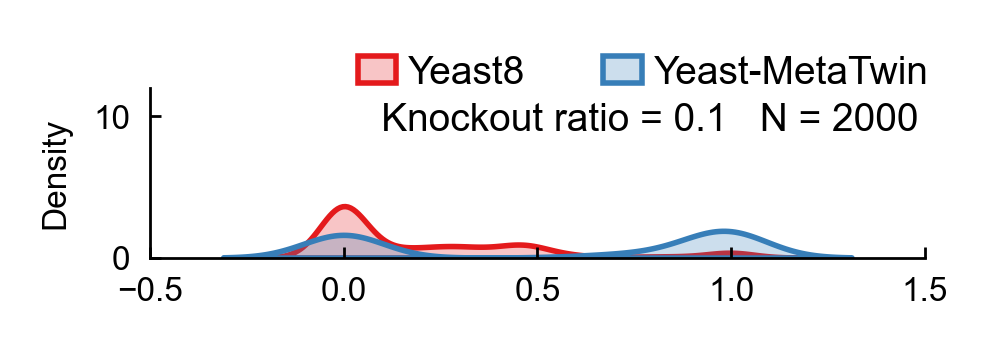

0.2
../../Results/Figures/figs6-d0.2.pdf


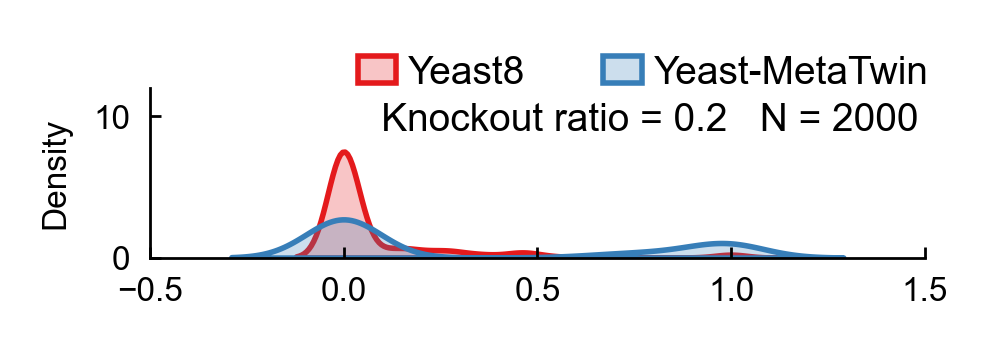

0.3
../../Results/Figures/figs6-d0.3.pdf


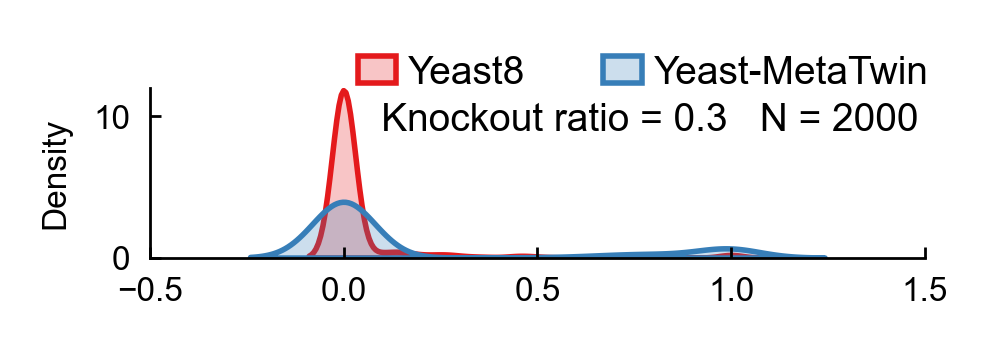

0.4
../../Results/Figures/figs6-d0.4.pdf


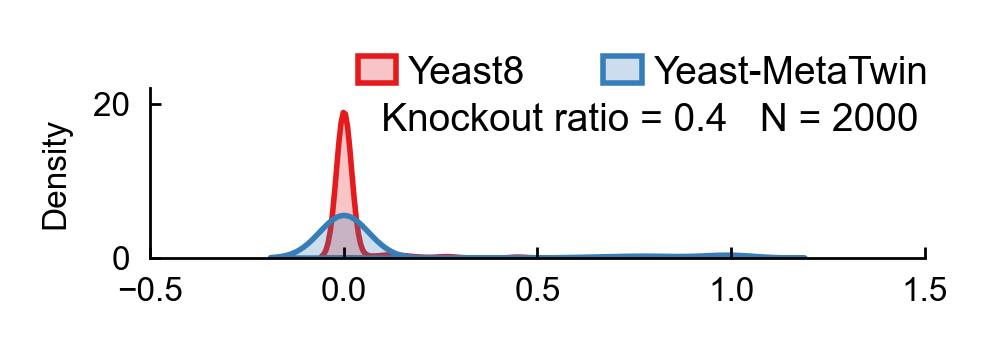

In [11]:
for i in range(1,5):
    print(i/10)
    ratio = i/10
    yeast8_score_lst = []
    yeast8U_score_lst = []
    for tmp_lst in yeast8_result_df[yeast8_result_df['knockratio']==ratio]['score'].to_list():
        yeast8_score_lst += tmp_lst
    for tmp_lst in yeast8U_result_df[yeast8U_result_df['knockratio']==ratio]['score'].to_list():
        yeast8U_score_lst += tmp_lst
    figure_path = figure_6a_path + str(ratio)+'.pdf'
    print(figure_path)
    if ratio<0.31:
        max_ylim = 12
    elif ratio<0.41:
        max_ylim = 22
    else:
        max_ylim = 32
    aminoacid = ''
    plot_dual_kernel_density(yeast8_score_lst, yeast8U_score_lst,figure_path,aminoacid,max_ylim,ratio)